In [1]:
# importing libraries
from os import getcwd, path
from pathlib import Path

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from typing import Set, List

from data_analysis_helper_fun import *

In [2]:
from data_analysis_helper_fun import normalized_heat_maps_by_weights

## Loading data

In [4]:
 # relative path to data directory
data_dir = path.join(Path(getcwd()).parent.absolute(), "data")
data_set_name = 're_data_tau_alpha_001-150'
data_file_name = f'{data_set_name}.csv.tar.gz'
re_data = load_re_data(data_dir, 
                                data_file_name,
                                usecols = ["model_name",
                                           'n_sentence_pool',
                                           "ds",
                                           "init_coms",
                                           "init_coms_dia_consistent",
                                           'weight_account', 
                                           'weight_systematicity',
                                           "go_coms_consistent",
                                           "fp_coms_consistent",
                                           "fixed_point_coms_consistent",
                                           "n_fixed_points",
                                           "n_global_optima"
                                           ],
                               evalcols = [
                                    'go_coms_consistent',
                                    'fp_coms_consistent',
                                   ])

In [5]:
# output directory
tables_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "tables")
figures_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "figures")

In [6]:
print('\033[1m' + 'General information: ' + '\033[0m')
print("   Amount of rows:" , len(re_data))
print('   Number of dialectical structures:', len(re_data['ds'].unique()))
print('   Overall number of initial commitments:', len(re_data['init_coms'].unique()))
print('   Sentence-pools:' , re_data['n_sentence_pool'].unique())
print('   Models:' , re_data['model_name'].unique())
print('\n')

General information: 
   Amount of rows: 1753906
   Number of dialectical structures: 150
   Overall number of initial commitments: 60
   Sentence-pools: [6 7 8]
   Models: ['QuadraticGlobalRE' 'LinearGlobalRE' 'QuadraticLocalRE' 'LinearLocalRE']




In [7]:
re_data.columns

Index(['model_name', 'ds', 'n_sentence_pool', 'weight_account',
       'weight_systematicity', 'init_coms', 'init_coms_dia_consistent',
       'fixed_point_coms_consistent', 'n_fixed_points', 'fp_coms_consistent',
       'n_global_optima', 'go_coms_consistent', 'model_short_name'],
      dtype='object')

## Setup dataframes

In [267]:
""" 
If `analyse_branches` is set to `true`, all branches of RE processes are considered for the analysis. 
This may lead to the multiple counting of a unique fixed point  
if they are reached on different paths from a simulation setup.
Otherwise, the subsequent analysis comprises only unique fixed points per simulation setup.
"""
analyse_branches = False



# control the grouping of the dataframe during aggregation 
grouping = ['model_name',
            #'ds',
            #'init_coms',
            #'weight_account',
            #'weight_systematicity'
           ]

# Whether resulting tables and figures are exported to the corresponing output directory"""
export_results = True

In [268]:
# the analysis of global optima is not affected by status of `analyse_branches`

# restrict data to unique simulation setups to prevent multiple counting of branches 
re_data_unique_setups = re_data.drop_duplicates(["model_name",
                         "ds",
                         #"n_sentence_pool",
                         'weight_account', 
                         'weight_systematicity',
                         #'weight_faithfulness', 
                         'init_coms'
                        ])

# restrict to relevant columns
go_data = re_data_unique_setups[["model_name",
                                 "ds",
                                 "init_coms",
                                 "weight_account", 
                                 "weight_systematicity", 
                                 "init_coms_dia_consistent", 
                                 "go_coms_consistent"]]

# explode information about global optima, which is stored rowwise (per simulation setup) 
# in lists (e.g. in the column `go_coms_consistent`) 
exploded_go_data = go_data.set_index(["model_name",
                                      "ds",
                                      "init_coms",
                                      "weight_account", 
                                      "weight_systematicity", 
                                      "init_coms_dia_consistent"]).apply(pd.Series.explode).reset_index()

exploded_go_data.shape

(1644574, 7)

In [269]:
if analyse_branches:
    
    # use all rows and restrict to relevant columns
    fp_data = re_data[["model_name",
                       "ds",
                       "init_coms",
                       "weight_account", 
                       "weight_systematicity", 
                       "init_coms_dia_consistent", 
                       "fixed_point_coms_consistent"]]
    
    # rename fixed point columns 
    # note: data is already exploded
    exploded_fp_data = fp_data.rename(columns={"fixed_point_coms_consistent": "fp_coms_consistent",})
    
else:
    
    # use unique setups and restrict to relevant columns
    fp_data = re_data_unique_setups[["model_name",
                                     "ds",
                                     "init_coms",
                                     "weight_account", 
                                     "weight_systematicity", 
                                     "init_coms_dia_consistent", 
                                     "fp_coms_consistent"]]
    
    # explode information about unique fixed points, which is stored rowwise (per simulation setup) 
    # in lists (e.g. in the column `go_coms_consistent`) 
    exploded_fp_data = fp_data.set_index(["model_name",
                                          "ds",
                                          "init_coms",
                                          "weight_account", 
                                          "weight_systematicity", 
                                          "init_coms_dia_consistent"]).apply(pd.Series.explode).reset_index()
    
exploded_fp_data.shape

(922824, 7)

In [270]:
# quick check: If `analyse_branches` is false, the length of exploed_fp_data 
# should be equal to the number of unique fixed points in the dataframe with unique setups
re_data_unique_setups["n_fixed_points"].sum()

922824

## Labelling cases

In [271]:
# conversion to type bool
exploded_go_data['init_coms_dia_consistent'] = exploded_go_data['init_coms_dia_consistent'].astype('bool')
exploded_go_data['go_coms_consistent'] = exploded_go_data['go_coms_consistent'].astype('bool')

In [272]:
# global optima
exploded_go_data['go_inconsistency_eliminating_case'] = (~exploded_go_data['init_coms_dia_consistent']) & exploded_go_data['go_coms_consistent']
exploded_go_data['go_consistency_preserving_case'] = exploded_go_data['init_coms_dia_consistent'] & exploded_go_data['go_coms_consistent']
exploded_go_data['go_inconsistency_preserving_case'] = (~exploded_go_data['init_coms_dia_consistent']) & (~exploded_go_data['go_coms_consistent'])
exploded_go_data['go_consistency_eliminating_case'] = (exploded_go_data['init_coms_dia_consistent']) & (~exploded_go_data['go_coms_consistent'])

In [273]:
display(exploded_go_data.head(6)[[#'global_optima',
                                  'init_coms_dia_consistent',
                                  'go_coms_consistent', 
                                  'go_inconsistency_eliminating_case',
                                  'go_consistency_preserving_case',
                                  'go_inconsistency_preserving_case',
                                  'go_consistency_eliminating_case'
                                 ]])

,init_coms_dia_consistent,go_coms_consistent,go_inconsistency_eliminating_case,go_consistency_preserving_case,go_inconsistency_preserving_case,go_consistency_eliminating_case
0,True,False,False,False,False,True
1,True,True,False,True,False,False
2,True,True,False,True,False,False
3,True,True,False,True,False,False
4,True,True,False,True,False,False
5,True,True,False,True,False,False


In [274]:
# conversion to type bool
exploded_fp_data['init_coms_dia_consistent'] = exploded_fp_data['init_coms_dia_consistent'].astype('bool')
exploded_fp_data['fp_coms_consistent'] = exploded_fp_data['fp_coms_consistent'].astype('bool')

In [275]:
# fixed points
exploded_fp_data['fp_inconsistency_eliminating_case'] = ~(exploded_fp_data['init_coms_dia_consistent']) & exploded_fp_data['fp_coms_consistent']
exploded_fp_data['fp_consistency_preserving_case'] = exploded_fp_data['init_coms_dia_consistent'] & exploded_fp_data['fp_coms_consistent']
exploded_fp_data['fp_inconsistency_preserving_case'] = ~(exploded_fp_data['init_coms_dia_consistent']) & ~(exploded_fp_data['fp_coms_consistent'])
exploded_fp_data['fp_consistency_eliminating_case'] = exploded_fp_data['init_coms_dia_consistent'] & ~(exploded_fp_data['fp_coms_consistent'])

In [276]:
display(exploded_fp_data.head(6)[[#'fixed_point', 
                                  'fp_coms_consistent', 
                                  'fp_inconsistency_eliminating_case',
                                  'fp_consistency_preserving_case',
                                  'fp_inconsistency_preserving_case',
                                  'fp_consistency_eliminating_case'
                                 ]])

,fp_coms_consistent,fp_inconsistency_eliminating_case,fp_consistency_preserving_case,fp_inconsistency_preserving_case,fp_consistency_eliminating_case
0,False,False,False,False,True
1,True,False,True,False,False
2,True,False,True,False,False
3,True,False,True,False,False
4,True,False,True,False,False
5,True,False,True,False,False


In [277]:
# count cases in a group
go_result_df = exploded_go_data[['model_name',
                                 "ds",
                                 "init_coms",
                                 'weight_account', 
                                 'weight_systematicity', 
                                 'go_coms_consistent', 
                                 'go_inconsistency_eliminating_case',
                                 'go_consistency_preserving_case',
                                 'go_inconsistency_preserving_case',
                                 'go_consistency_eliminating_case']].groupby(grouping).agg('sum').reset_index()

# count total number of global optima in a group
go_result_df['n_global_optima'] = go_result_df.apply(lambda x: sum(x[col] for col in ['go_inconsistency_eliminating_case',
                                 'go_consistency_preserving_case',
                                 'go_inconsistency_preserving_case',
                                 'go_consistency_eliminating_case']) , axis=1)

#go_result_df.reset_index(inplace=True)

In [278]:
go_result_df.shape

(4, 9)

In [279]:
go_result_df["n_global_optima"].sum()

1644574

In [280]:
re_data_unique_setups["n_global_optima"].sum()

1644574

In [281]:
# count cases in a group
fp_result_df = exploded_fp_data[['model_name',
                                 'ds',
                                 'init_coms',
                                 'weight_account', 
                                 'weight_systematicity', 
                                 'fp_coms_consistent', 
                                 'fp_inconsistency_eliminating_case',
                                 'fp_consistency_preserving_case',
                                 'fp_inconsistency_preserving_case',
                                 'fp_consistency_eliminating_case']].groupby(grouping).agg('sum').reset_index()

# count total number of fixe points in a group
fp_result_df['n_fixed_points'] = fp_result_df.apply(lambda x: sum(x[col] for col in ['fp_inconsistency_eliminating_case',
                                 'fp_consistency_preserving_case',
                                 'fp_inconsistency_preserving_case',
                                 'fp_consistency_eliminating_case']) , axis=1)

#fp_result_df.reset_index(inplace=True)

In [282]:
fp_result_df.shape

(4, 9)

In [283]:
fp_result_df["n_fixed_points"].sum()

922824

## Tables

### XX

In [284]:
# relative share of consistency cases

for df, endpoint_type in zip([fp_result_df, go_result_df], ['fp', 'go']):
    for case_name in ["inconsistency_eliminating", 
                      "consistency_preserving", 
                      "inconsistency_preserving", 
                      "consistency_eliminating"]:
        
        endpoint_name = "n_global_optima" if endpoint_type == "go" else "n_fixed_points"
    
        relative_share_col_name = 'rel_' + endpoint_type + '_' + case_name + '_case' 
        
        df[relative_share_col_name] = df[endpoint_type + '_' + case_name + '_case']/df[endpoint_name]

In [285]:
# group by model name and calculate average

fp_overall_results = fp_result_df.groupby(['model_name',
                     #'ds',
                     #'init_coms',
                     #'weight_account',
                     #'weight_systematicity'
                     ])[["rel_fp_inconsistency_eliminating_case",
                         "rel_fp_consistency_preserving_case",
                         "rel_fp_inconsistency_preserving_case",
                         "rel_fp_consistency_eliminating_case"]].mean().reset_index()


go_overall_results = go_result_df.groupby(['model_name',
                     #'ds',
                     #'init_coms',
                     #'weight_account',
                     #'weight_systematicity'
                     ])[["rel_go_inconsistency_eliminating_case",
                         "rel_go_consistency_preserving_case",
                         "rel_go_inconsistency_preserving_case",
                         "rel_go_consistency_eliminating_case"]].mean().reset_index()

In [286]:
overall_result_df = go_overall_results.join(fp_overall_results.set_index("model_name"), on="model_name")
overall_result_df

,model_name,rel_go_inconsistency_eliminating_case,rel_go_consistency_preserving_case,rel_go_inconsistency_preserving_case,rel_go_consistency_eliminating_case,rel_fp_inconsistency_eliminating_case,rel_fp_consistency_preserving_case,rel_fp_inconsistency_preserving_case,rel_fp_consistency_eliminating_case
0,LinearGlobalRE,0.235055,0.550357,0.200064,0.014524,0.181986,0.576458,0.233869,0.007687
1,LinearLocalRE,0.235055,0.550357,0.200064,0.014524,0.270633,0.548637,0.172560,0.008170
2,QuadraticGlobalRE,0.216620,0.542092,0.211554,0.029735,0.205223,0.551040,0.222822,0.020916
3,QuadraticLocalRE,0.198111,0.530922,0.238301,0.032665,0.211550,0.491916,0.276367,0.020167


In [287]:
overall_result_df = go_overall_results.join(fp_overall_results.set_index("model_name"), on="model_name")
overall_result_df

,model_name,rel_go_inconsistency_eliminating_case,rel_go_consistency_preserving_case,rel_go_inconsistency_preserving_case,rel_go_consistency_eliminating_case,rel_fp_inconsistency_eliminating_case,rel_fp_consistency_preserving_case,rel_fp_inconsistency_preserving_case,rel_fp_consistency_eliminating_case
0,LinearGlobalRE,0.235055,0.550357,0.200064,0.014524,0.181986,0.576458,0.233869,0.007687
1,LinearLocalRE,0.235055,0.550357,0.200064,0.014524,0.270633,0.548637,0.172560,0.008170
2,QuadraticGlobalRE,0.216620,0.542092,0.211554,0.029735,0.205223,0.551040,0.222822,0.020916
3,QuadraticLocalRE,0.198111,0.530922,0.238301,0.032665,0.211550,0.491916,0.276367,0.020167


In [288]:
# Preparing the dataframe for csv export

# Changing col names for readability
cols_for_tables = {'model_name':'Model',
                   "rel_go_inconsistency_eliminating_case": "Relative share of inconsistency eliminating cases among global optima",
                   "rel_go_consistency_preserving_case": "Relative share of consistency preserving cases among global optima",
                   "rel_go_inconsistency_preserving_case": "Relative share of inconsistency preserving cases among global optima",
                   "rel_go_consistency_eliminating_case": "Relative share of consistency eliminating cases among global optima",
                   "rel_fp_inconsistency_eliminating_case": "Relative share of inconsistency eliminating cases among fixed points",
                   "rel_fp_consistency_preserving_case": "Relative share of consistency preserving cases among fixed points",
                   "rel_fp_inconsistency_preserving_case": "Relative share of inconsistency preserving cases among fixed points",
                   "rel_fp_consistency_eliminating_case": "Relative share of consistency eliminating cases among fixed points",
                  }

display(overall_result_df.rename(columns=cols_for_tables))


# Exporting relevant cols
if export_results:
    file_name = 'table_consistency_cases_go_fp_{}.csv'.format('branches' if analyse_branches else 'setups')
    overall_result_df[['model_name',
                       "rel_go_inconsistency_eliminating_case",
                       "rel_go_consistency_preserving_case",
                       "rel_go_inconsistency_preserving_case",
                       "rel_go_consistency_eliminating_case",
                       "rel_fp_inconsistency_eliminating_case",
                       "rel_fp_consistency_preserving_case",
                       "rel_fp_inconsistency_preserving_case",
                       "rel_fp_consistency_eliminating_case"]].rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, file_name), index=False)

,Model,Relative share of inconsistency eliminating cases among global optima,Relative share of consistency preserving cases among global optima,Relative share of inconsistency preserving cases among global optima,Relative share of consistency eliminating cases among global optima,Relative share of inconsistency eliminating cases among fixed points,Relative share of consistency preserving cases among fixed points,Relative share of inconsistency preserving cases among fixed points,Relative share of consistency eliminating cases among fixed points
0,LinearGlobalRE,0.235055,0.550357,0.200064,0.014524,0.181986,0.576458,0.233869,0.007687
1,LinearLocalRE,0.235055,0.550357,0.200064,0.014524,0.270633,0.548637,0.172560,0.008170
2,QuadraticGlobalRE,0.216620,0.542092,0.211554,0.029735,0.205223,0.551040,0.222822,0.020916
3,QuadraticLocalRE,0.198111,0.530922,0.238301,0.032665,0.211550,0.491916,0.276367,0.020167


## Plots

In [289]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

In [290]:
# color palette
viridis = ["#472c7a", "#2c718e", "#29ae80", "#b0dd31"]
viridis_light = ["rgba(71, 44, 122, 0.5)", "rgba(44, 113, 142, 0.5)", "rgba(41, 174, 128, 0.5)", "rgba(176, 221, 49, 0.5)"]

### Barplots

#### Overall barplots across configuration of weights

In [291]:
def barplot(data, endpoint_type):
    
    
    y_cols = ["rel_{}_inconsistency_eliminating_case".format(endpoint_type),
              "rel_{}_consistency_preserving_case".format(endpoint_type),
              "rel_{}_inconsistency_preserving_case".format(endpoint_type),
              "rel_{}_consistency_eliminating_case".format(endpoint_type)]
    
    fig3 = px.bar(data.round(3), 
                  x="model_name", 
                  y=y_cols, 
                  barmode="stack", 
                  text_auto=True)

    fig3.update_yaxes(range=[0.0, 1.0])
    fig3.update_traces(name="Consistency preserving (CP)", 
                       marker_color=viridis[2], 
                       selector=dict(name='rel_{}_consistency_preserving_case'.format(endpoint_type)))
    
    fig3.update_traces(name="Inconsistency eliminating (IE)", 
                       marker_color=viridis[3],
                       selector=dict(name='rel_{}_inconsistency_eliminating_case'.format(endpoint_type)))
    
    fig3.update_traces(name="Inconsistency preserving (IP)",
                       marker_color=viridis[1],
                       selector=dict(name='rel_{}_inconsistency_preserving_case'.format(endpoint_type)))
    
    fig3.update_traces(name="Consistency eliminating (CE)",
                       marker_color=viridis[0], 
                       selector=dict(name="rel_{}_consistency_eliminating_case".format(endpoint_type)))

    fig3.update_layout(template="plotly_white",
                       #paper_bgcolor="#e9e8e6",
                       #plot_bgcolor="#e9e8e6",
                       font={"color": "black", "size":12},
                       width=860,
                       margin={"t":80}
                      )

    fig3.update_xaxes(title="Model variant", showticklabels=True, showgrid=False, linecolor= 'DarkGrey')
    fig3.update_yaxes(title="Relative share", ticks="outside", tickcolor="DarkGrey", showgrid=False, linecolor='DarkGrey', zeroline=True, zerolinecolor="DarkGrey",
                      zerolinewidth=1)
    fig3.update_layout(legend_title_text="")
    fig3.update_layout(legend={'traceorder':'reversed', 
                              "orientation":"v", "x":1.0, "y":1.025, "xanchor":"left"})
    fig3.update_layout(title_text="Relative share of consistency cases among {}".format("global optima" if endpoint_type=="go" else "fixed points"))
    fig3.update_traces(opacity=0.8)
    fig3.show()



    if export_results:
        file_name = 'overall_consistency_cases_{}_{}.png'.format(endpoint_type, 'branches' if analyse_branches else 'setups')
        fig3.write_image(path.join(figures_output_dir, file_name), scale=2)

In [292]:
barplot(go_overall_results, "go")
barplot(fp_overall_results, "fp")

#### Barplots by configuration of weights

In [293]:
new_grouping = ['model_name', 'weight_account','weight_systematicity']

In [303]:
# fixed_points

# count cases in a group
fp_df = exploded_fp_data[['model_name',
                                 'ds',
                                 'init_coms',
                                 'weight_account', 
                                 'weight_systematicity', 
                                 'fp_coms_consistent', 
                                 'fp_inconsistency_eliminating_case',
                                 'fp_consistency_preserving_case',
                                 'fp_inconsistency_preserving_case',
                                 'fp_consistency_eliminating_case']].groupby(new_grouping).agg('sum').reset_index()

# count total number of fixe points in a group
fp_df['n_fixed_points'] = fp_df.apply(lambda x: sum(x[col] for col in ['fp_inconsistency_eliminating_case',
                                 'fp_consistency_preserving_case',
                                 'fp_inconsistency_preserving_case',
                                 'fp_consistency_eliminating_case']) , axis=1)




In [304]:
# global optima

# count cases in a group
go_df = exploded_go_data[['model_name',
                                 "ds",
                                 "init_coms",
                                 'weight_account', 
                                 'weight_systematicity', 
                                 'go_coms_consistent', 
                                 'go_inconsistency_eliminating_case',
                                 'go_consistency_preserving_case',
                                 'go_inconsistency_preserving_case',
                                 'go_consistency_eliminating_case']].groupby(new_grouping).agg('sum').reset_index()

# count total number of global optima in a group
go_df['n_global_optima'] = go_df.apply(lambda x: sum(x[col] for col in ['go_inconsistency_eliminating_case',
                                 'go_consistency_preserving_case',
                                 'go_inconsistency_preserving_case',
                                 'go_consistency_eliminating_case']) , axis=1)

#go_result_df.reset_index(inplace=True)

In [306]:
# relative share of consistency cases

for df, endpoint_type in zip([fp_df, go_df], ['fp', 'go']):
    for case_name in ["inconsistency_eliminating", 
                      "consistency_preserving", 
                      "inconsistency_preserving", 
                      "consistency_eliminating"]:
        
        endpoint_name = "n_global_optima" if endpoint_type == "go" else "n_fixed_points"
    
        relative_share_col_name = 'rel_' + endpoint_type + '_' + case_name + '_case' 
        
        df[relative_share_col_name] = df[endpoint_type + '_' + case_name + '_case']/df[endpoint_name]

In [307]:
def transform_y(y):
    if y<0.999:
        return y
    return -0.15

In [308]:
def barplot_by_weight(data, endpoint_type):
    
    y_cols = ["rel_{}_inconsistency_eliminating_case".format(endpoint_type),
              "rel_{}_consistency_preserving_case".format(endpoint_type),
              "rel_{}_inconsistency_preserving_case".format(endpoint_type),
              "rel_{}_consistency_eliminating_case".format(endpoint_type)]

    fig = px.bar(data, x="model_name", y=y_cols,
                 facet_row="weight_systematicity", 
                 facet_col="weight_account",
                 facet_row_spacing=0.07, # default is 0.07 when facet_col_wrap is used
                 facet_col_spacing=0.04, # default is 0.03
                 text_auto=False
                )
    fig.update_traces(name="Consistency preserving (CP)", 
                       marker_color=viridis[2], 
                       selector=dict(name='rel_{}_consistency_preserving_case'.format(endpoint_type)))
    
    fig.update_traces(name="Inconsistency eliminating (IE)", 
                       marker_color=viridis[3],
                       selector=dict(name='rel_{}_inconsistency_eliminating_case'.format(endpoint_type)))
    
    fig.update_traces(name="Inconsistency preserving (IP)",
                       marker_color=viridis[1],
                       selector=dict(name='rel_{}_inconsistency_preserving_case'.format(endpoint_type)))
    
    fig.update_traces(name="Consistency eliminating (CE)",
                       marker_color=viridis[0], 
                       selector=dict(name="rel_{}_consistency_eliminating_case".format(endpoint_type)))
    fig.update_xaxes(title="", showticklabels=True, showgrid=False, linecolor= 'DarkGrey')
    fig.update_yaxes(title="",)

    #legend
    fig.update_layout(legend_title_text="")
    fig.update_layout(legend={'traceorder':'reversed', 
                              "orientation":"v", "x":1.0, "y":1.025, "xanchor":"left"})

    # annotations
    fig.for_each_annotation(lambda a: a.update(text=a.text.replace("weight_account=", ""), y=transform_y(a.y)))
    fig.for_each_annotation(lambda a: a.update(text=a.text.replace("weight_systematicity=", "")))

    #fig.for_each_annotation(lambda a: print(a))

    fig.add_annotation(text="Weight account", xref="paper", yref="paper", x= 0.5, y=-0.2, showarrow=False)
    fig.add_annotation(text="Weight systematicity", xref="paper", yref="paper", x= 1.05, y=0.5, showarrow=False, textangle=90)



    fig.update_layout(template="plotly_white",
                       #paper_bgcolor="#e9e8e6",
                       #plot_bgcolor="#e9e8e6",
                       font={"color": "black", "size":12},
                       width=1860,
                       height=1000,
                       margin={"t":80}
                      )

    fig.update_layout(title_text="Relative share of consistency cases among {}".format("global optima" if endpoint_type=="go" else "fixed points"))

    fig.update_xaxes(showticklabels=False)
    
    fig.show()
    
    if export_results:
        file_name = 'weight_consistency_cases_{}_{}.png'.format(endpoint_type, 'branches' if analyse_branches else 'setups')
        fig.write_image(path.join(figures_output_dir, file_name), scale=2)

In [309]:
barplot_by_weight(go_df, "go")
barplot_by_weight(fp_df, "fp")

### Heatmaps

In [311]:
def case_heatmaps_by_weights(data, endpoint_type, case_name, analyse_branches):
    
    display_std = False
    metric = "Relative"
    branches=""
    
    if analyse_branches:
        display_std = False
        metric = "Relative"
        branches = " (all branches)" if endpoint_type=="fp" else ""
         
    #number_of_endpoints = "n_global_optima" if endpoint_type == "go" else "n_fixed_points"
    
    relative_share = 'rel_' + endpoint_type + '_' + case_name + '_case' 
        
    #data[relative_share] = data[endpoint_type + '_' + case_name + '_case']/data[number_of_endpoints]
    
    display_case_name = " ".join(case_name.split("_"))
    display_endpoint_type = "global optima" if endpoint_type == "go" else "fixed points"
    
    normalized_heat_maps_by_weights(re_data = data, 
                     values = relative_share, 
                     title = '{} share of {} cases for {}{}'.format(metric, display_case_name, display_endpoint_type, branches), 
                     annot_std = display_std,
                     annot_fmt="{:2.2f}\n", 
                     annot_std_fmt = r'$\pm${:2.1f}')

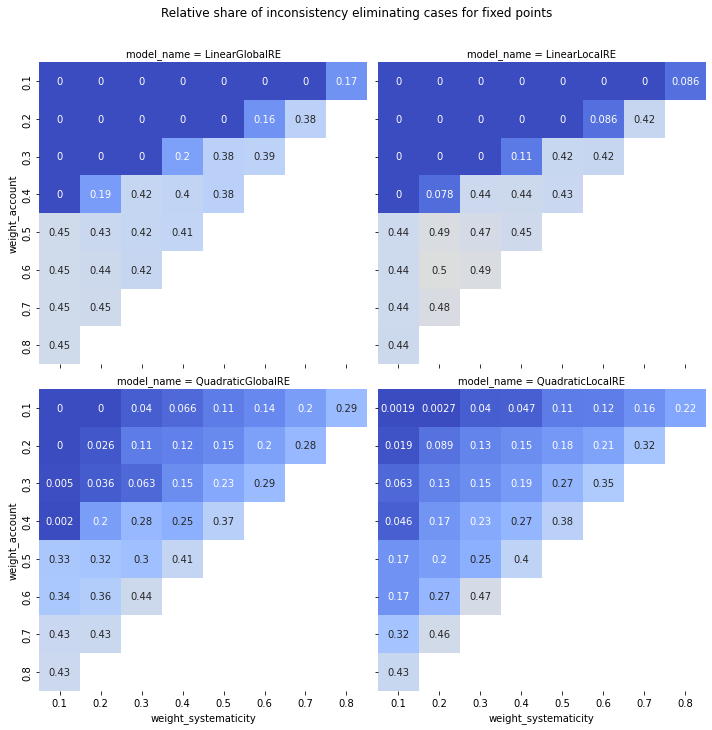

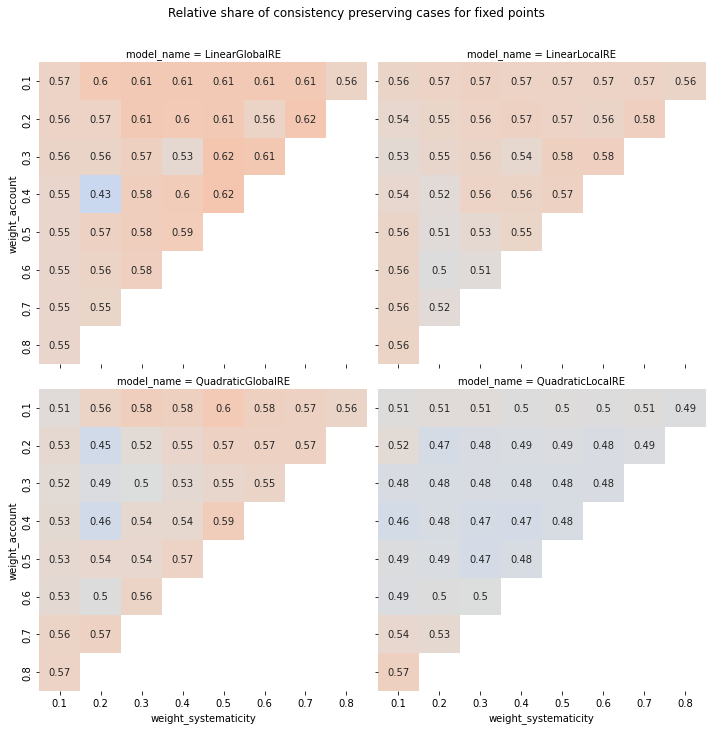

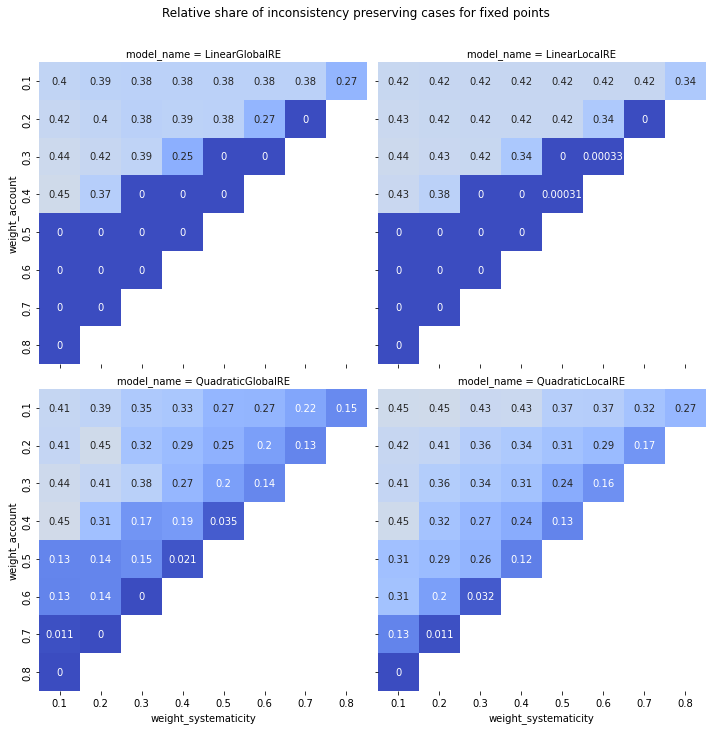

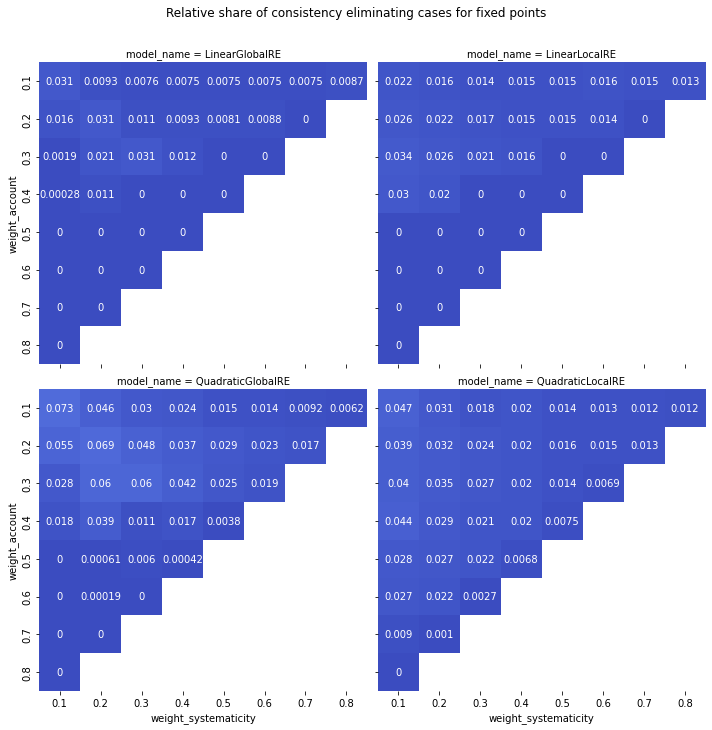

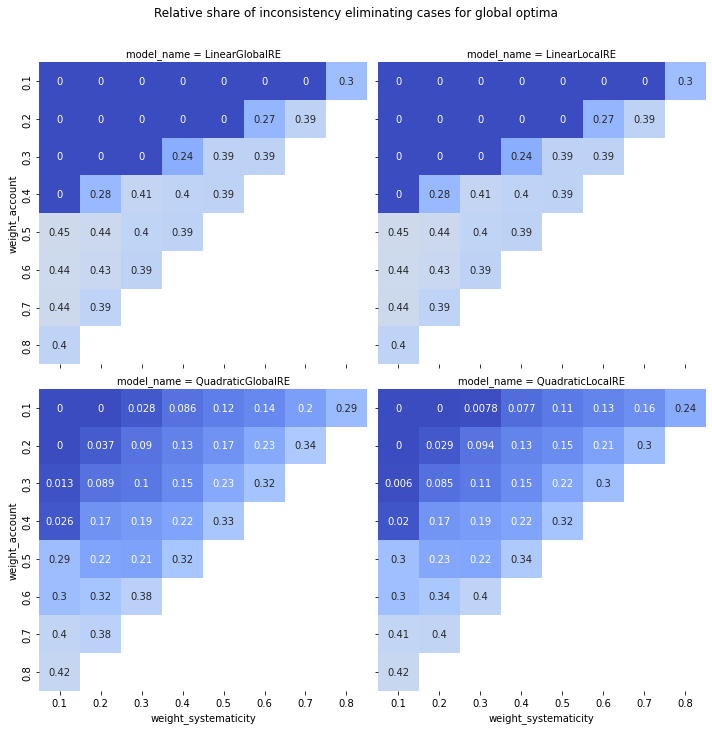

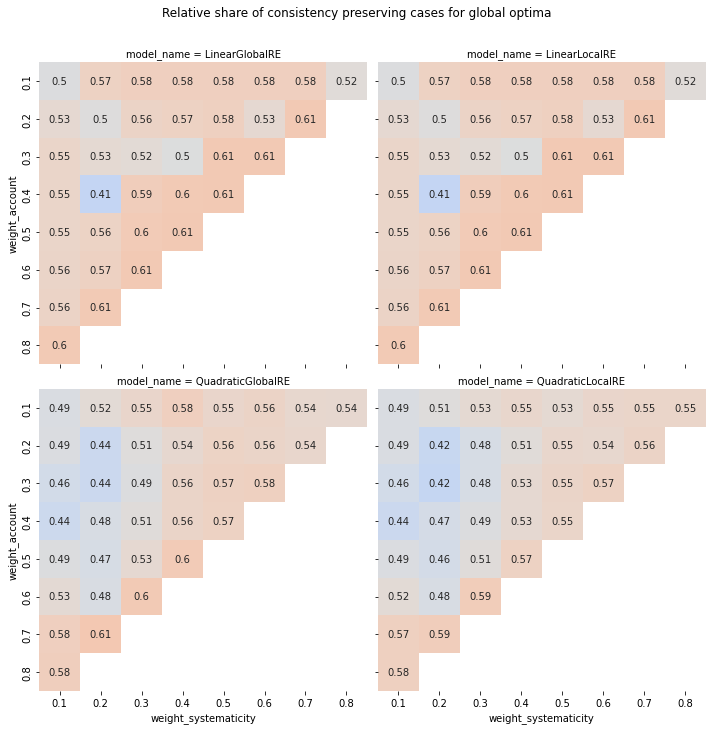

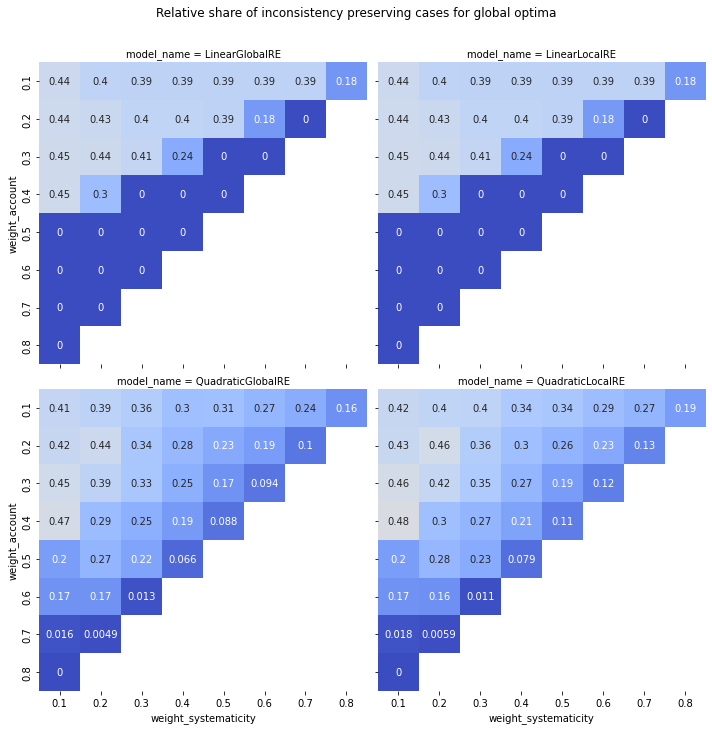

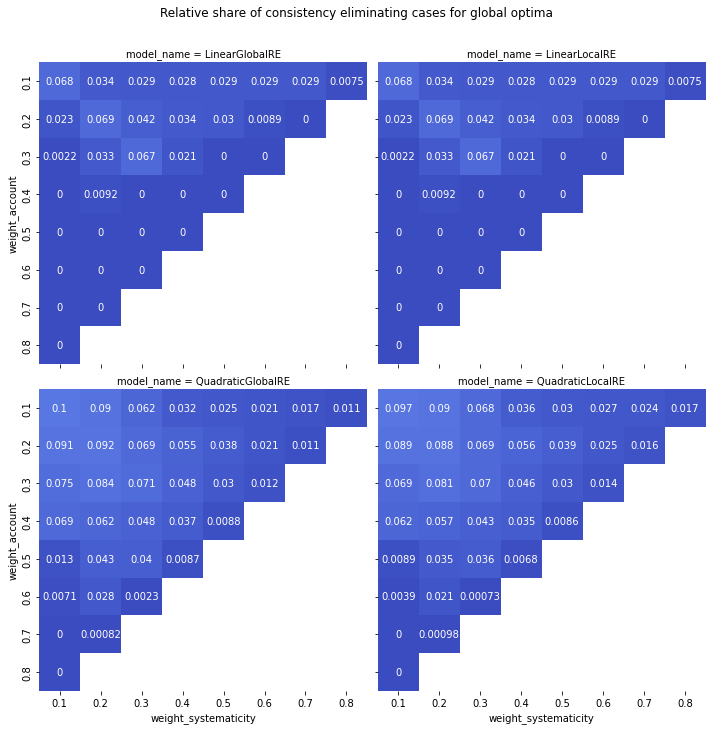

In [312]:
for df, endpoint_type in zip([fp_df, go_df], ['fp', 'go']):
    for case_name in ["inconsistency_eliminating", 
                      "consistency_preserving", 
                      "inconsistency_preserving", 
                      "consistency_eliminating"]:
        
        case_heatmaps_by_weights(df, endpoint_type, case_name, analyse_branches)
        
        branches = "branches" if analyse_branches else "setups"
        
        if export_results:
            plt.savefig(path.join(figures_output_dir, '{}_{}_cases_{}.png'.format(endpoint_type, case_name, branches)), bbox_inches='tight')
            plt.savefig(path.join(figures_output_dir, '{}_{}_cases_{}.pdf'.format(endpoint_type, case_name, branches)), bbox_inches='tight')